#Fundametals of Probabilistic Data Minig LAB 3

## Authors: Zeinab Abdallah, Lucas Batier, Ionut-Vlad Modoranu, Predrag Pilipovic

### See formulas to update the model at the end of the notebook

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import math
import itertools
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
print('loaded libraries')

loaded libraries


# No need to upload digamma.py because the method is here, in the notebook

In [0]:
def digamma(x):
#  Check the input.
  if ( x <= 0.0 ):
    value = 0.0
    ifault = 1
    return value, ifault
#  Initialize.
  ifault = 0
  value = 0.0
#  Use approximation for small argument.
  if ( x <= 0.000001 ):
    euler_mascheroni = 0.57721566490153286060
    value = - euler_mascheroni - 1.0 / x + 1.6449340668482264365 * x
    return value, ifault
#  Reduce to DIGAMA(X + N).
  while ( x < 8.5 ):
    value = value - 1.0 / x
    x = x + 1.0
#  Use Stirling's (actually de Moivre's) expansion.
  r = 1.0 / x
  value = value + np.log ( x ) - 0.5 * r
  r = r * r
  value = value - r * ( 1.0 / 12.0 - r * ( 1.0 / 120.0 - r * ( 1.0 / 252.0 - r * ( 1.0 / 240.0 - r * ( 1.0 / 132.0 ) ) ) ) )
  return value, ifault
print('loaded digamma')

loaded digamma


In [0]:
def accuracy_with_all_permutations(GroundTruth_Assignment, Estimated_Assignments):
    """
        - This function should be used when the label assignment of our EM
    algorithm (Estimated_Assignments) are different from GroundTruth_Assignment
        - This function performs all permutations over Estimated_Assignments and
    then compares them with ground truth. All accuracies are saved in a list that
    is sorted descending by accuracy before returning it
        - How to use this function: simply write accuracy_with_all_permutations()
    in a code cell and it will print a list of pairs containing
    (accuracy, permutation) meaning "the accuracy that we obtained by permuting
    the labels in Estimated_Assignments using 'permutation'"
    """
    permutations = list(itertools.permutations(range(K), K))
    #   This list keeps (accuracy, permutation) denoting the accuracy obtained
    # by permuting the labels with "permutation"
    perm_accuracies = []
    
    for perm in permutations:
        pred = np.copy(Estimated_Assignments) # duplicate predictions
        # modify prediction vector using permutation
        for i in range(N):
            pred[i] = perm[pred[i]]
            
        # START professor's code to compute accuracy
        acc = 0
        for k in range(K):
            acc += np.sum(pred[GroundTruth_Assignment==col_ind[k]]==row_ind[k])
        acc = round(acc / N * 100., 3)
        # END professor's code to compute accuracy

        # save the pair (acc, perm) and sort the list descending by accuracy
        perm_accuracies.append((acc, perm))
        perm_accuracies = sorted(perm_accuracies, key=lambda x: -x[0])
    return perm_accuracies
print('loaded accuracy_with_all_permutations')

loaded accuracy_with_all_permutations


In [0]:
def VEM(init_type, val_N, val_K, val_o, show_plots=False):
    """
        This function does the following:
        - set global variables
        - set model parameters
        - set ground truth values
        - initialization
        - iterations for M, E-z, E-mu and E-nu steps
        - evaluation (computing accuracy and mean vector distance)
        - it also shows some plots if show_plots=True
        Returns: a 3-tuple containing (error, acc, mvd, x)
        - if error = True, then the metrics and data cannot be used (an error occured)
        - if error = False, then the metrics and data can be used (no error occured)
    """
    # initialize some VEM parameters given method parameters
    N = val_N # number of samples
    K = val_K # number of clusters
    GroundTruth_omega = val_o # diagonal value of covariance for mean prior

    #################### GLOBAL VARIABLES
    #################################################################
    Dx=2 # Dimension of the observation space
    nIter = 10 # VEM Iterations
    eps = 1e-10 # value to add in E-z step
    colors = ['r','g','b']
    
    #################################################################
    #################### MODEL PARAMETERS (SAME FOR ALL SEQS)
    #################################################################
    ## Components weights
    GroundTruth_pi_k = (1.0/K)*np.ones((1,K))
    ## Prior for the means
    # Mean of the mean prior
    GroundTruth_m = np.zeros((Dx))
    # Covariance of the mean prior
    ### GroundTruth_omega = 100 # this line is removed and put at the beginning of while - let it commented!
    GroundTruth_Omega = GroundTruth_omega*np.identity(Dx)
    ## Priof of the variance
    GroundTruth_alpha = 40
    alpha = GroundTruth_alpha # No estimation of the parameter alpha
    GroundTruth_beta = 0.1
    
    #################################################################
    #################### ASSIGN GROUND TRUTH
    #################################################################
    GroundTruth_Assignment = np.random.randint(0,K,N)
    ## The means
    GroundTruth_Means = np.random.multivariate_normal(mean = GroundTruth_m, cov = GroundTruth_Omega, size = K)
    ## The variances
    GroundTruth_Variances = np.random.gamma(shape = GroundTruth_alpha, scale = GroundTruth_beta, size = K)
    ## Generate the observations
    x = np.zeros((Dx,N))
    for no in range(N):
        target_index = GroundTruth_Assignment[no];
        x[:,no] = np.random.multivariate_normal(mean = GroundTruth_Means[target_index,:], cov = GroundTruth_Variances[target_index]*np.identity(Dx))
    
    if show_plots:
        plt.title('ground truth assignments')
        plt.plot(x[0,:],x[1,:],'ob')
        for k in range(K):
            plt.plot(x[0,GroundTruth_Assignment==k],x[1,GroundTruth_Assignment==k],'o'+colors[k])
        plt.show()

        plt.title('data without assignments')
        plt.plot(x[0, :], x[1, :], "ob")
        plt.show()

    #################################################################
    #################### INITIALISATION
    #################################################################
    if init_type == 'random':
        # Option 1: Select randomly K observations
        selected_obs = np.random.choice(range(N),K)
        m_k = x[:,selected_obs]
    elif init_type == 'ground_truth':
        # Option 2: Ground truth initialisation
        m_k = GroundTruth_Means.copy()
        m_k = np.transpose(m_k)
    elif init_type == 'kmeans':
        # Option 3: using KMeans
        kmeans = KMeans(n_clusters=K)
        kmeans.fit(x.T)
        m_k = kmeans.cluster_centers_.T

    # Initialise Omega_k to identity
    Omega_k = np.zeros((Dx,Dx,K))
    for k in range(K):
        Omega_k[:,:,k] = np.identity(Dx)
    ## Assignments
    lambda_nk = np.zeros((N,K))
    # Compute distance from each observation to the new means
    distances = np.zeros((N,K))
    for n in range(N):
        for k in range(K):
            distances[n,k] = np.linalg.norm(m_k[:,k]-x[:,n])
        # Closest mean
        kmin = np.argmin(distances[n,:])
        # Hard assignment initialisation
        lambda_nk[n,kmin] = 1

    ## Initialise the posterior parameters of the gamma distribution to zero, they are the first to be computed
    alpha_k = alpha*np.ones((K))
    # Rate parameter
    beta_k = np.zeros((K))
    eta_k = np.zeros((K))
    rho_k = np.zeros((K))
    for k in range(K):
        # Average cluster distance
        avg_dist_k = np.average( distances[lambda_nk[:,k]==1,k] )
        # beta = (alpha-1)*average + 1
        # the "+1" avoids singularities
        beta_k[k] = (alpha_k[k]-1)*avg_dist_k + 1
        # Now we can compute eta_k and rho_k
        eta_k[k] = np.log(beta_k[k]) - digamma(alpha_k[k])[0]
        rho_k[k] = alpha_k[k]/beta_k[k]
    
    if show_plots:
        plt.title('hard-assignment after the initialization')
        plt.plot(x[0,:],x[1,:],'ob')
        Plot_Assignments = np.argmax(lambda_nk,axis=1)
        for k in range(K):
            plt.plot(x[0,Plot_Assignments==k],x[1,Plot_Assignments==k],'o'+colors[k])
        plt.show()
    #################################################################
    #################### VARIATIONAL EXPECTATION MAXIMIZATION (VEM)
    #################################################################
    ## Allocate parameters
    pi_k = np.zeros((K))
    m = np.zeros((Dx))
    Omega = np.zeros((Dx,Dx))
    beta = 0
    Omega_k_inv = np.zeros((Dx,Dx,K))

    ## Iterate
    for it in range(nIter):
        #################################################################
        #################### M step
        #################################################################
        pi_k = 1/N*np.sum(lambda_nk, axis = 0)
        m = 1/K*np.sum(m_k, axis = 1)
        Omega_temp = np.zeros((Dx,Dx))
        for k in range(K):
            Omega_temp = Omega_temp + np.outer((m_k[:, k] - m), (m_k[:, k] - m)) + Omega_k[:, :, k]
        Omega = Omega_temp/K
        Omega_inv = np.linalg.inv(Omega)
        beta = K*alpha/np.sum(rho_k)

        #################################################################
        #################### E-z step
        #################################################################
        for n in range(N):
            numerator = np.zeros((K))
            for k in range(K):
                numerator[k] = eps + pi_k[k]*np.exp(-1/2*(Dx*eta_k[k] + rho_k[k]*(np.linalg.norm(x[:, n] - m_k[:, k])**2 + np.matrix.trace(Omega_k[:, :, k]))))
            denominator = np.sum(numerator)
            lambda_nk[n, :] = numerator/denominator


        #################################################################
        #################### E-mu step
        #################################################################
        for k in range(K):
            Omega_k_inv[:,:,k] = Omega_inv + (eps + rho_k[k]*np.sum(lambda_nk[:, k]))*np.identity(Dx)
            Omega_k[:,:,k] = np.linalg.inv(Omega_k_inv[:,:,k])
            sum_term_m = np.zeros((Dx))
            for n in range(N):
                sum_term_m = sum_term_m + lambda_nk[n,k]*x[:,n]
            m_k[:, k] = np.dot(Omega_k[:,:,k], np.dot(Omega_inv, m) + rho_k[k]*sum_term_m)

        ## E-nu step
        alpha_k = alpha + Dx/2*np.sum(lambda_nk, axis = 0)
        for k in range(K):
            sum_term_beta = 0
            for n in range(N):
                sum_term_beta = sum_term_beta + lambda_nk[n,k]*(np.linalg.norm(x[:, n]-m_k[:, k])**2+np.matrix.trace(Omega_k[:, :, k]))
            beta_k[k] = beta + 1/2*sum_term_beta 
            eta_k[k] = np.log(beta_k[k]) - digamma(alpha_k[k])[0]
            rho_k[k] = alpha_k[k]/beta_k[k]

    if show_plots:
        plt.title('estimated hard-assignment plot')
        plt.plot(x[0,:],x[1,:],'ob')
        Plot_Assignments = np.argmax(lambda_nk,axis=1)
        for k in range(K):
            plt.plot(x[0,Plot_Assignments==k],x[1,Plot_Assignments==k],'o'+colors[k])
        plt.show()
    
    #################################################################
    #################### VEM RESULTS EVALUATION
    #################################################################
    ### Evaluation of the VEM results
    ## Find the optimal cluster assignment
    # Compute the cost of assigning cluster k, to ground-truth cluster l
    cluster_assignment_cost = np.zeros((K,K))
    for k in range(K):
        for l in range(K):
            cluster_assignment_cost[k,l] = np.sum(lambda_nk[GroundTruth_Assignment==l,k])
    try:
        ### Usually, errors happen here: cluster_assignment_cost has NaN values and
        ### method linear_sum_assignment is throwing an exception
        
        # Obtain the ground-truth-to-estiamted cluster assignment
        row_ind, col_ind = linear_sum_assignment(-cluster_assignment_cost)
    except:
        ### If linear_sum_assignment throws an exception, stop function here and return False, -1, -1
        return True, -1, -1, None

    ## Compute L2 distance between means
    mvd = 0
    for k in range(K):
        mvd = mvd + np.linalg.norm(m_k[:,row_ind[k]]-GroundTruth_Means[col_ind[k],:])

    ## Compute the clasification error
    # Optimal found assignment
    Estimated_Assignments = np.argmax(lambda_nk, axis=1)
    acc = 0
    for k in range(K):
        acc = acc + np.sum(Estimated_Assignments[GroundTruth_Assignment==col_ind[k]]==row_ind[k])
    acc = float(acc) / N * 100.
    return False, acc, mvd, x
print('loaded VEM')

loaded VEM


# Run one iteration of VEM, see data plots and metrics

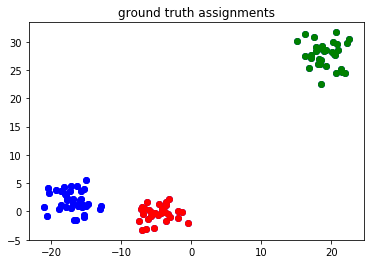

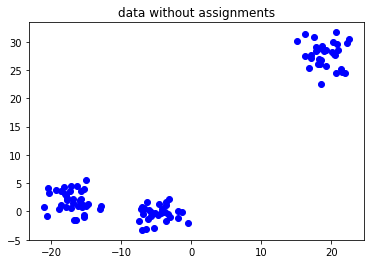

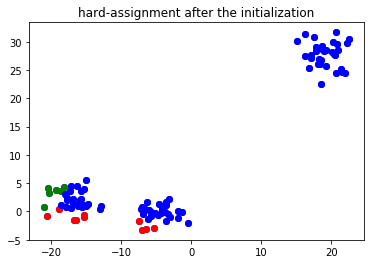

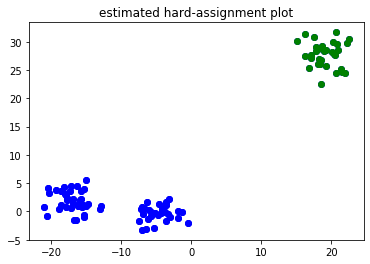

Accuracy: 69.0
Mean Vector Distance: 24.743705219919224
You can access the data by using variable x


In [0]:
# init_type can be 'random', 'ground_truth' or 'kmeans'
error, acc, mvd, x = VEM(init_type='random', val_N=100, val_K=3, val_o=100, show_plots=True)
if error:
    print(f'An error occured during optimization, please run again')
else:
    print(f'Accuracy: {acc}')
    print(f'Mean Vector Distance: {mvd}')
    print('You can access the data by using variable x')

# Sensitivity Analysis: this solves 3.3.3 (c and d) and 3.4.3 (c and d)
## To change initialization of means: use different values for variable "init_type"
## To change parameters for sensitivity analysis: use variable "in_test"

In [0]:
# init_type = 'random'
# init_type = 'ground_truth'
init_type = 'kmeans'

in_test = 'N' # select this if you test N
# in_test = 'K' # select this if you test K
# in_test = 'o' # select this if you test omega

Ng = 100 # N = number of samples
Kg = 3   # K = number of clusters
og = 100 # omega = diagonal value for covariance matrix for mean prior

proportions_N = [0.25, 0.5, 1, 2, 4] # the proportions to apply to Ng
proportions_K = [1, 2, 3, 4, 5]      # the proportions to apply to Kg
proportions_o = [0.25, 0.5, 1, 2, 4] # the proportions to apply to og

# create all values for N, K and o
N_values = [int(Ng * p) for p in proportions_N]
K_values = [int(Kg * p) for p in proportions_K]
o_values = [int(og * p) for p in proportions_o]

values = None  # this will change depending on the test we perform: for N, N or omega
if in_test == 'N':
    values = N_values
elif in_test == 'K':
    values = K_values
elif in_test == 'o':
    values = o_values

# create dictionary for metrics: key = Ng, value = array of size R containing metric for steps 1...R
dict_mvd = dict([(v, []) for v in values])
dict_acc = dict([(v, []) for v in values])

R = 50
errors = 0
print(f'Running Sensitivity Analysis for {in_test} with {init_type} initialization')
for val in values: # values is the list depending on in_test
    # count how many metrics were computed successfully (without error)
    # skip the error when it is caught (at this time, the variable no_metrics_successfully_computed will not increase)
    no_metrics_successfully_computed = 0
    while no_metrics_successfully_computed < R:
        #################################################################
        #################### SET N, K, omega DEPENDING ON in_test
        #################################################################
        if in_test == 'N': # we test for values of N: keep K and omega to ground
            N = val
            K = Kg
            o = og
        elif in_test == 'K':  # we test for values of K: keep N and omega to ground
            N = Ng
            K = val
            o = og
        elif in_test == 'o':  # we test for values of omega: keep N and K to ground
            N = Ng
            K = Kg
            o = val
        
        error, acc, mvd, x = VEM(init_type, N, K, o, show_plots=False)
        if error:
            continue # this skips next steps and goes back to while evaluation
        dict_acc[val].append(acc)
        dict_mvd[val].append(mvd)        
        
        ### If we are successful, increase the number of successfully computed metrics
        no_metrics_successfully_computed += 1
print(f'Done! Total errors: {errors} (all errors were skipped using try-catch and replaced with new fresh runs)')

Running Sensitivity Analysis for N with kmeans initialization
Done! Total errors: 0 (all errors were skipped using try-catch and replaced with new fresh runs)


# Sensitivity Analysis plots

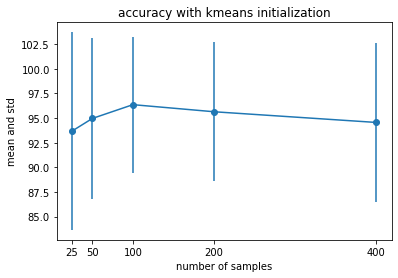

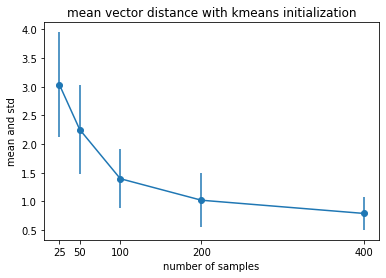

In [0]:
for name, d in [('accuracy', dict_acc), ('mean vector distance', dict_mvd)]:
    x = values
    y = [np.array(d[n]).mean() for n in values]
    y_err = [np.array(d[n]).std() for n in values]

    plt.errorbar(x=x, y=y, yerr=y_err, marker='o')
    
    plt.title(f'{name} with {init_type} initialization')
    plt.xticks(values)
    plt.ylabel('mean and std')
    
    if in_test == 'N':
        plt.xlabel('number of samples')
    elif in_test == 'K':
        plt.xlabel('number of clusters')
    elif in_test == 'o':
        plt.xlabel('cov of mean prior')
    
    plt.show() # comment this to have one figure with both graphs

# Formulas to update the model at the end of the notebook

## M step:
\begin{align*}
\pi_k^* &= \frac{1}{N}\sum\limits_{n=1}^N \lambda_{n,k}\\
\mathbf{m}^* &= \frac{1}{K}\sum_{k=1}^K \mathbf{m}_k\\
\mathbf{\Omega}^* &= \frac{1}{K}\sum_{k=1}^K (\mathbf{m}_k - \mathbf{m}^*)(\mathbf{m}_k - \mathbf{m}^*)^T + \mathbf{\Omega}_k\\
\beta^* &= \frac{K\alpha^{\text{old}}}{\sum\limits_{k=1}^K \rho_k}
\end{align*}

## E-$z$ step:
\begin{align*}
\lambda_{n,k} &= \frac{\pi_{k}^{\text {old }} \exp \left(-\frac{1}{2}\left[d_{x} \eta_{k}+\rho_{k}\left(\left\|\mathbf{x}_{n}-\mathbf{m}_{k}\right\|^{2}+\operatorname{Tr}\left(\mathbf{\Omega}_{k}\right)\right)\right]\right)+\varepsilon}{\sum\limits_{\ell=1}^{K} \left[\pi_{\ell}^{\text {old }} \exp \left(-\frac{1}{2}\left[d_{x} \eta_{\ell}+\rho_{\ell}\left(\left\|\mathbf{x}_{n}-\mathbf{m}_{\ell}\right\|^{2}+\operatorname{Tr}\left(\mathbf{\Omega}_{\ell}\right)\right)\right]\right)+\varepsilon\right]}
\end{align*}

## E-$\mu$ step:
\begin{equation*}
q_{\boldsymbol{\mu}}\left(\boldsymbol{\mu}_{k}\right)=\mathcal{N}\left(\boldsymbol{\mu}_{k} ; \mathbf{m}_{k}, \boldsymbol{\Omega}_{k}\right),
\end{equation*}
with 
\begin{align*}
\mathbf{\Omega}_{k}^{-1}&=(\mathbf{\Omega}^{\text{old}})^{-1} + \left(\varepsilon + \rho_k \sum\limits_{n=1}^N \lambda_{n,k}\right)\mathbf{I}_{d_x}\\
\mathbf{m}_{k}&=\mathbf{\Omega}_{k}\left(\left(\mathbf{\Omega}^{\mathrm{old}}\right)^{-1} \mathbf{m}^{\mathrm{old}}+\rho_{k} \sum_{n=1}^{N} \lambda_{n, k} \mathbf{x}_{n}\right)
\end{align*}

## E-$\nu$ step:

$$q_\nu({\nu}_k) = \mathcal{IG}({\nu}_k; \alpha_k, \beta_k),$$
with
\begin{align*}
\alpha_k &= \alpha^{\text{old}} + \frac{d_x}{2}\sum_{n=1}^N \lambda_{n,k},\\
\beta_k &= \beta^{\text{old}} + \frac{1}{2}\sum_{n=1}^N \lambda_{n,k} \left(\| \mathbf{x}_n - \mathbf{m}_k \|^2 + \text{Tr}(\mathbf{\Omega}_k)\right).
\end{align*}